<a href="https://colab.research.google.com/github/Kosuke20020715/Data-Analytics/blob/main/SEOAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Website Traffic Analysis


## 目的
Webサイトに訪問するユーザーのCV率や滞在時間、離脱率や維持率を分析・把握することで各パラメータの特徴や傾向を理解することができる。それにより、効率的にSEO施策を打つことが可能になることが期待される。本検証では、実際の企業サイトにおけるCVデータをとる前に、Kaggleのデータセットを利用して今後の活用への展望や課題点を検証する。

https://www.kaggle.com/datasets/anthonytherrien/website-traffic


## データの理解

In [ ]:
#import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/website_wata.csv")
df.head(5)

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
0,5,11.051381,0.230652,Organic,3.890460,3,1.0
1,4,3.429316,0.391001,Social,8.478174,0,1.0
2,4,1.621052,0.397986,Organic,9.636170,2,1.0
3,5,3.629279,0.180458,Organic,2.071925,3,1.0
4,5,4.235843,0.291541,Paid,1.960654,5,1.0


### 特徴量の設定


*   Page Views : 1セッションあたりに開かれたページ数 <p>
ユーザーがどれ程興味を示しているか
*   Session Duration : サイトの滞在時間 [min] <p>
ユーザーの興味や満足度に影響
*   Bounce Rate : 1ページだけで帰った人の割合<p> 離脱度の高さを示す
*   Traffic Source : どこから訪問したか<p>
広告効果や流入元の比較が可能
*   Time on Page : 特定のページでの滞在時間<p>
どのページに興味を持っているかがわかる
*   Previous Visits : 過去に訪問した回数<p>
リピーターの傾向がわかる
*   Conversion Rate : 目標達成率<p>
商品の購入や会員登録などの目標達成を示す



### データの確認

In [ ]:
df_null = df.isnull()
df_null.sum()

,0
Page Views,0
Session Duration,0
Bounce Rate,0
Traffic Source,0
Time on Page,0
Previous Visits,0
Conversion Rate,0


欠損値はこのことから存在しないことが判明した。

In [ ]:

df["Traffic Source"].unique()

array(['Organic', 'Social', 'Paid', 'Direct', 'Referral'], dtype=object)

In [ ]:
df['Conversion Rate'].value_counts()

,count
Conversion Rate,
1.000000,1773
0.963080,1
0.868593,1
0.972277,1
0.892856,1
...,...
0.791405,1
0.565124,1
0.997645,1


### 相関関係

<function matplotlib.pyplot.show(close=None, block=None)>

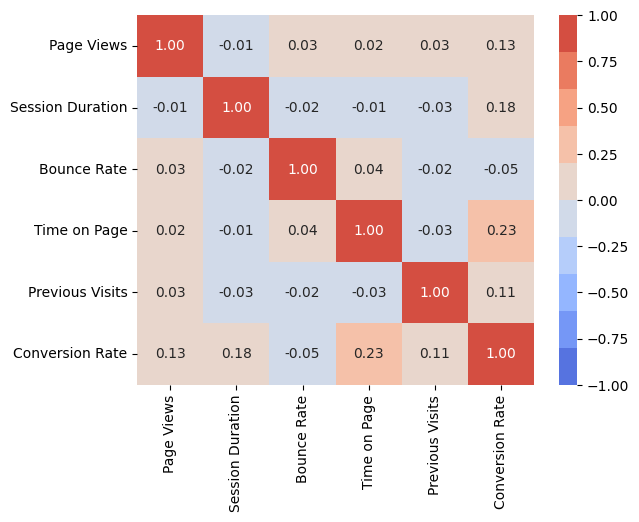

In [ ]:
df_corr = df[["Page Views","Session Duration", "Bounce Rate", "Time on Page", "Previous Visits", "Conversion Rate"]].corr()
sns.heatmap(df_corr,cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)
plt.show

全体的に相関関係は薄いことが分析され、相対的に大きい相関をもつものは、**{Time on Page : Conversion Rate} {Session Duration : Conversion Rate}**のみであることも相関ヒートマップから読み取れる

<function matplotlib.pyplot.show(close=None, block=None)>

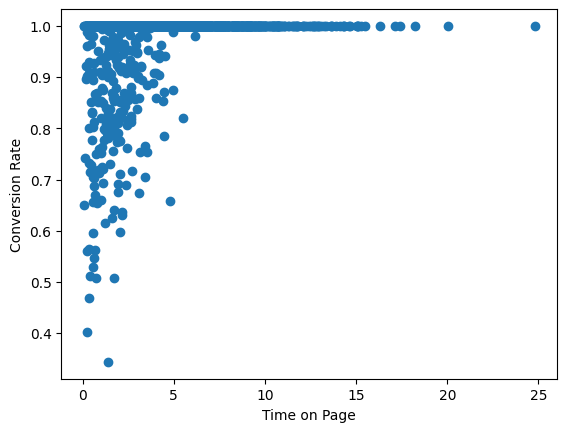

In [ ]:
plt.scatter(df['Time on Page'],df['Conversion Rate'])
plt.xlabel('Time on Page')
plt.ylabel('Conversion Rate')
plt.show

## データの前処理
今後、回帰問題として学習する場合、外れ値をパラメータごとに確認する必要がある。本セクションでは、外れ値の確認をseabornを用いて行う。<p>
ここでは、外れ値の定義を次のように定める。<p>
第一四分位数 = Q1,第三四分位数 = Q3, 四分位範囲 = IQR<p>
と定義するとき、**"Q1-1.5IQR未満 or Q3+1.5IQRを超える**"データを外れ値とする。

### 外れ値の可視化

<function matplotlib.pyplot.show(close=None, block=None)>

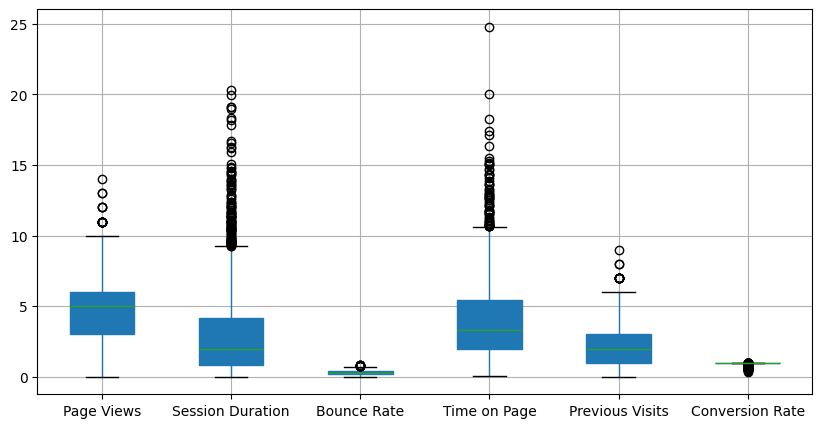

In [ ]:
#箱ひげ図の表示
plt.figure(figsize=(10,5))
df.boxplot(patch_artist = True)
plt.show

箱ひげ図から任意のパラメータについて外れ値が存在していることが読み取れる。(本来はそれぞれのスケーリングを変えるべきである)したがって、今後の作業はこれらの外れ値を除去することが重要になる。

In [ ]:
df_des = df.describe()
df_des

,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits,Conversion Rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4.950500,3.022045,0.284767,4.027439,1.978500,0.982065
std,2.183903,3.104518,0.159781,2.887422,1.432852,0.065680
min,0.000000,0.003613,0.007868,0.068515,0.000000,0.343665
25%,3.000000,0.815828,0.161986,1.935037,1.000000,1.000000
50%,5.000000,1.993983,0.266375,3.315316,2.000000,1.000000
75%,6.000000,4.197569,0.388551,5.414627,3.000000,1.000000
max,14.000000,20.290516,0.844939,24.796182,9.000000,1.000000


In [ ]:
Q1 = df_des.loc["25%"][:]
Q3 = df_des.loc["75%"][:]
lQR = Q3-Q1
out1 = Q1-1.5*lQR
out2 = Q3+1.5*lQR

#外れ値の除去
columns = ["Page Views","Session Duration", "Bounce Rate", "Time on Page", "Previous Visits", "Conversion Rate"]
for column in columns:
  new_df = df[(df[column] >= out1[column]) & (df[column] <= out2[column])]
new_df.describe()

,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits,Conversion Rate
count,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.0
mean,5.064862,3.259028,0.280867,4.301298,2.055274,1.0
std,2.192428,3.198786,0.156977,2.926783,1.447459,0.0
min,0.000000,0.004258,0.007868,0.068515,0.000000,1.0
25%,3.000000,0.943448,0.161348,2.174493,1.000000,1.0
50%,5.000000,2.306391,0.262971,3.645431,2.000000,1.0
75%,6.000000,4.528622,0.381574,5.685453,3.000000,1.0
max,14.000000,20.290516,0.837279,24.796182,9.000000,1.0


### ヒートマップ(外れ値除去後)

<function matplotlib.pyplot.show(close=None, block=None)>

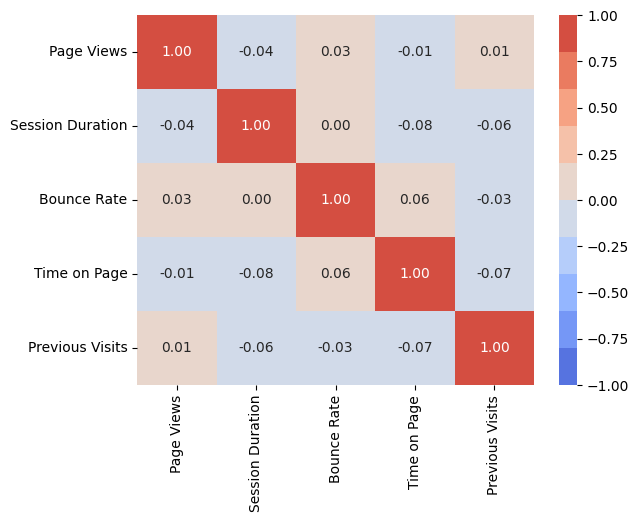

In [ ]:
df_corr = new_df[["Page Views","Session Duration", "Bounce Rate", "Time on Page", "Previous Visits"]].corr()
sns.heatmap(df_corr,cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)
plt.show

Conversion Rateに関しては、すべての値が1になってしまったので相関が計算することができなくなったと考えられる。<p>
相対的に相関係数の大きさが高いのは、**{"Bounce Rate":"Time on Page"} {"Time on Page":"Session Duration"} {"Time on Page":"Previous Visits"}** の3つに変化した。

### 散布図による分析
先ほどのヒートマップにおいて微妙に相関関係がみられたデータについて、散布図を用いて分析を行う

<function matplotlib.pyplot.show(close=None, block=None)>

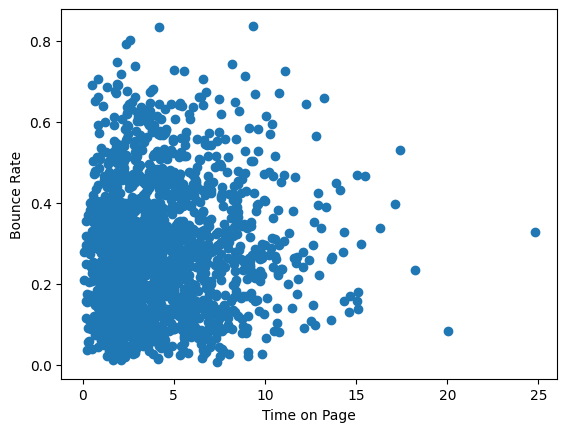

In [ ]:
plt.scatter(new_df['Time on Page'],new_df['Bounce Rate'])
plt.xlabel('Time on Page')
plt.ylabel('Bounce Rate')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

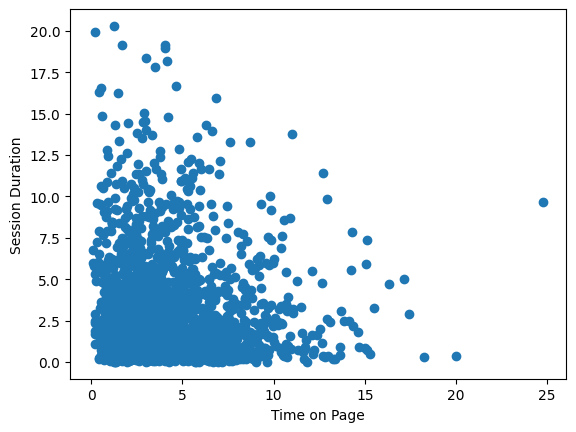

In [ ]:
plt.scatter(new_df['Time on Page'],new_df['Session Duration'])
plt.xlabel('Time on Page')
plt.ylabel('Session Duration')
plt.show

## 考察

### Conversion Rateについて
下のヒストグラムはConversion Rateの頻度を表したものである。これを見てもわかる通り、明らかに1が高頻度で出現しているため、不均衡データに分類されてしまう。つまり、何らかのモデルで回帰問題として(ex. Linear Regression) "Conversion Rate" を予想したいと思うとき, 当然ほとんどの解答が1になることが予想される。これは一見正答率が高いように思われるが、少数の値を予測することが困難となってしまう。(実際に、混同行列を用いてみればわかる。) 対処法としては、多数のデータを減少させるか、少数のデータを増やすというものがあるが、結局は全体の正答率は低下してしまう。(トレードオフ)<p>
ここでは、そのような状況を加味しながら目標である"Conversion Rate"を線形回帰により予測するという問題解決を図る。

<function matplotlib.pyplot.show(close=None, block=None)>

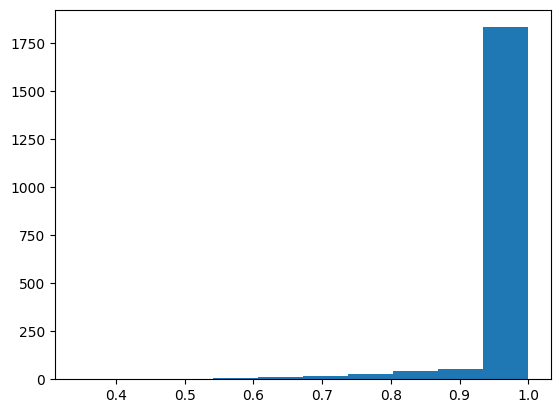

In [ ]:
plt.hist(df["Conversion Rate"])
plt.show

In [ ]:
#線形回帰問題
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

#目的変数/説明変数
X=df[["Page Views","Session Duration", "Bounce Rate", "Time on Page", "Previous Visits"]]
y=df["Conversion Rate"]

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model=LinearRegression()
model.fit(X_train,Y_train)

#交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(model, X, y, cv=kf, scoring='r2')
score_mean = score.mean()
print(f'each division:{score}')
print(f'mean:{score_mean}')


each division:[0.10057851 0.08704398 0.11373485 0.1053243  0.10084202]
mean:0.10150473153102575


・R2スコアが低いのは, "Conversion Rate"の多くが1である一方で, それ以外の場合に的中させることが困難であるからであると考えられる. <p>
・よりConversion Rateにばらつきがあるデータを活用することができれば、回帰問題としてR2スコアを1に近づけることが可能になるのではないかと分析する.
